<a href="https://colab.research.google.com/github/saisantoshmalladi01/Image-Classification-with-ResNet/blob/main/CECS_550_Project_Classification_with_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import the Necessary Libraries

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import layers, models, datasets, utils

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt


Data Loading and Preprocessing

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Convert labels to one-hot vectors
train_labels = utils.to_categorical(train_labels)
test_labels = utils.to_categorical(test_labels)


170498071/170498071 [==============================] - 11s 0us/step


**Iteration 1**


Build the Resnet block and architecture

In [ ]:
def resnet_block(inputs, num_filters, kernel_size, strides, activation='relu'):
    x = layers.Conv2D(num_filters, kernel_size=kernel_size, strides=strides, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Conv2D(num_filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Add Residual Connection
    shortcut = layers.Conv2D(num_filters, kernel_size=1, strides=strides)(inputs)
    shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation(activation)(x)
    return x

def build_resnet(input_shape, num_classes, layer_configs):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(16, (3,3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Adding resnet blocks
    for num_filters, kernel_size, strides in layer_configs:
        x = resnet_block(x, num_filters, kernel_size, strides)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# Configure your model (example configuration)
layer_configs = [
    (32, 3, 1),
    (32, 3, 2),
    (64, 3, 2),
    (128, 3, 2)
]
model = build_resnet((32, 32, 3), 10, layer_configs)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 16)           448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 16)           64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 32, 32, 16)           0         ['batch_normalization[0][0

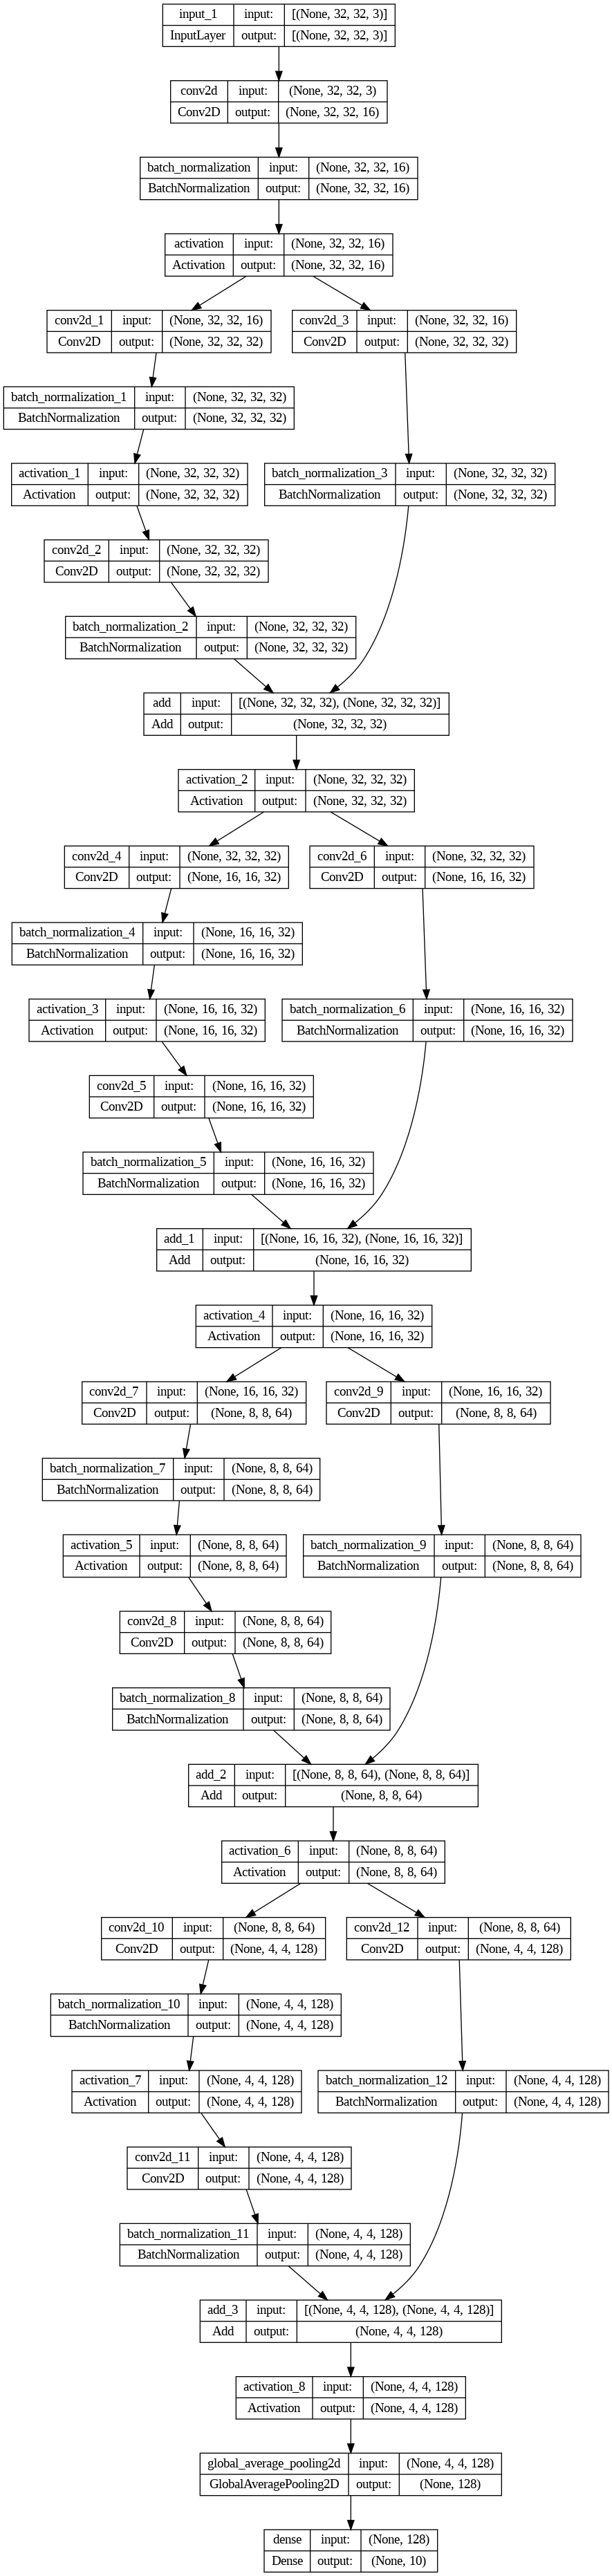

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_diagram.png', show_shapes=True, show_layer_names=True)

Compile the Model and train

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels))


Epoch 1/10
1563/1563 [==============================] - 28s 11ms/step - loss: 1.2576 - accuracy: 0.5454 - val_loss: 1.3136 - val_accuracy: 0.5523
Epoch 2/10
1563/1563 [==============================] - 15s 10ms/step - loss: 0.8635 - accuracy: 0.6931 - val_loss: 0.8921 - val_accuracy: 0.6834
Epoch 3/10
1563/1563 [==============================] - 15s 10ms/step - loss: 0.6976 - accuracy: 0.7562 - val_loss: 0.8196 - val_accuracy: 0.7195
Epoch 4/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.5800 - accuracy: 0.7973 - val_loss: 0.8628 - val_accuracy: 0.7072
Epoch 5/10
1563/1563 [==============================] - 15s 10ms/step - loss: 0.4957 - accuracy: 0.8267 - val_loss: 0.6853 - val_accuracy: 0.7625
Epoch 6/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.4155 - accuracy: 0.8539 - val_loss: 0.8208 - val_accuracy: 0.7242
Epoch 7/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.3525 - accuracy: 0.8776 - val_loss: 0.7387 -

Saving the Iteration 1 Model file

In [ ]:
model_path = '/content/drive/My Drive/Model Files/model.h5'
model.save(model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Plot the graph to visualize potential Issues. The below graph trend clearly shows overfitting as there as a considerable gap bettwen traning error and validation error

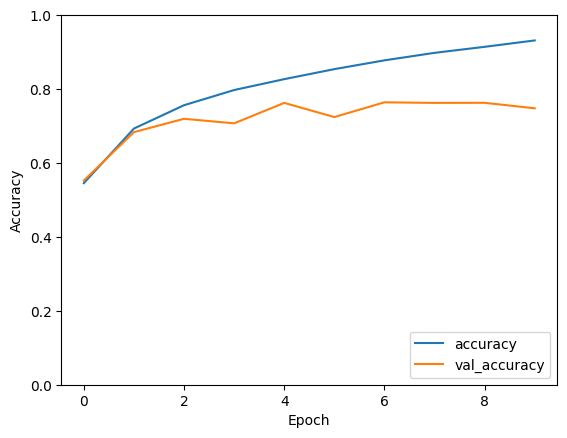

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


Evaluating the test accuracy

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test accuracy: {test_acc}")


313/313 - 1s - loss: 0.9344 - accuracy: 0.7479 - 1s/epoch - 3ms/step
Test accuracy: 0.7479000091552734


**Iterations 2 & 3**

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05), # This was 0.1 in Iteration 2
    layers.RandomZoom(0.05),
])


Updated Resnet block and architecture with Dropout L2 Regularization and data augementation to address overfitting

In [ ]:
from tensorflow.keras.regularizers import l2
# ResNet block with optional dropout
def resnet_block_updated(inputs, num_filters, kernel_size, strides, activation='relu', use_dropout=False, l2_factor=0.001):
    x = layers.Conv2D(num_filters, kernel_size=kernel_size, strides=strides, padding='same',kernel_regularizer=l2(l2_factor))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Conv2D(num_filters, kernel_size=kernel_size, strides=1, padding='same',kernel_regularizer=l2(l2_factor))(x)
    x = layers.BatchNormalization()(x)
    if use_dropout:  # Add dropout if parameter is set
        x = layers.Dropout(0.1)(x) # This was 0.2 in Iteration 2
    shortcut = layers.Conv2D(num_filters, kernel_size=1, strides=strides, padding='same',kernel_regularizer=l2(l2_factor))(inputs)
    shortcut = layers.BatchNormalization()(shortcut)
    x = layers.add([x, shortcut])
    x = layers.Activation(activation)(x)
    return x

# Build the ResNet model with optional data augmentation and dropout
def build_resnet_updated(input_shape, num_classes, layer_configs, use_dropout=False, use_augmentation=False, l2_factor=0.001):
    inputs = layers.Input(shape=input_shape)
    x = inputs
    if use_augmentation:  # Apply data augmentation if parameter is set
        x = data_augmentation(x)
    x = layers.Conv2D(16, (3,3), padding='same', kernel_regularizer=l2(l2_factor))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    for num_filters, kernel_size, strides in layer_configs:
        x = resnet_block_updated(x, num_filters, kernel_size, strides, use_dropout=use_dropout)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax', kernel_regularizer=l2(l2_factor))(x)
    model = models.Model(inputs, outputs)
    return model


layer_configs = [(32, 3, 1), (32, 3, 2), (64, 3, 2), (128, 3, 2)]
model_updated = build_resnet_updated((32, 32, 3), 10, layer_configs, use_dropout=True, use_augmentation=True)
model_updated.summary()




Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 32, 32, 3)            0         ['input_2[0][0]']             
                                                                                                  
 conv2d_13 (Conv2D)          (None, 32, 32, 16)           448       ['sequential[0][0]']          
                                                                                                  
 batch_normalization_13 (Ba  (None, 32, 32, 16)           64        ['conv2d_13[0][0]']           
 tchNormalization)                                                                          

Compile and train the model

In [ ]:
# Compile and train the model
model_updated.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_updated = model_updated.fit(train_images, train_labels, epochs=35, validation_data=(test_images, test_labels))

Epoch 1/35
1563/1563 [==============================] - 30s 14ms/step - loss: 1.8554 - accuracy: 0.4961 - val_loss: 1.7519 - val_accuracy: 0.5189
Epoch 2/35
1563/1563 [==============================] - 21s 14ms/step - loss: 1.3967 - accuracy: 0.6187 - val_loss: 1.4903 - val_accuracy: 0.6119
Epoch 3/35
1563/1563 [==============================] - 21s 14ms/step - loss: 1.2533 - accuracy: 0.6647 - val_loss: 1.4233 - val_accuracy: 0.6273
Epoch 4/35
1563/1563 [==============================] - 21s 14ms/step - loss: 1.1789 - accuracy: 0.6898 - val_loss: 1.1825 - val_accuracy: 0.6984
Epoch 5/35
1563/1563 [==============================] - 21s 14ms/step - loss: 1.1278 - accuracy: 0.7129 - val_loss: 1.3172 - val_accuracy: 0.6693
Epoch 6/35
1563/1563 [==============================] - 21s 13ms/step - loss: 1.0946 - accuracy: 0.7221 - val_loss: 1.3832 - val_accuracy: 0.6422
Epoch 7/35
1563/1563 [==============================] - 21s 14ms/step - loss: 1.0639 - accuracy: 0.7334 - val_loss: 1.2217 -

Evaluating the model with test accuracy

In [ ]:

# Evaluate the model
test_loss_updated, test_acc_updated = model_updated.evaluate(test_images, test_labels, verbose=2)
print(f"Test accuracy: {test_acc_updated}")

313/313 - 1s - loss: 0.9205 - accuracy: 0.7797 - 1s/epoch - 3ms/step
Test accuracy: 0.779699981212616


Saving the Updated model file

In [ ]:
model_path = '/content/drive/My Drive/Model Files/model_updated.h5'
model_updated.save(model_path)

Plotting to see potential issues. We see pretty good convergence

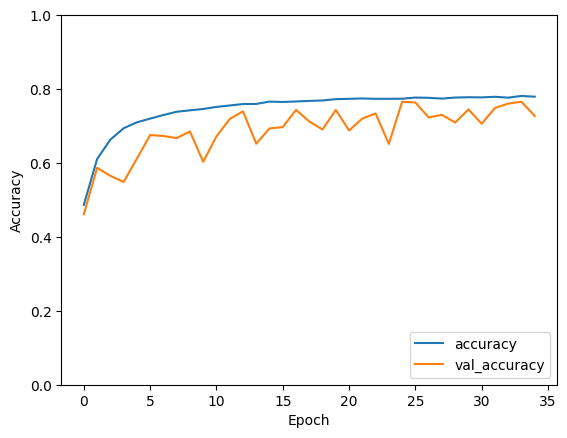

In [ ]:
plt.plot(history_updated.history['accuracy'], label='accuracy')
plt.plot(history_updated.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

**Result Measurement and Analysis**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict the test set
predictions = model_updated.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=[str(i) for i in range(10)]))


313/313 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.82      0.79      0.80      1000
           1       0.88      0.92      0.90      1000
           2       0.80      0.59      0.68      1000
           3       0.75      0.49      0.60      1000
           4       0.73      0.81      0.77      1000
           5       0.82      0.64      0.72      1000
           6       0.64      0.94      0.76      1000
           7       0.82      0.84      0.83      1000
           8       0.90      0.83      0.86      1000
           9       0.73      0.95      0.83      1000

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.77     10000
weighted avg       0.79      0.78      0.77     10000



**Confusion Matrix**

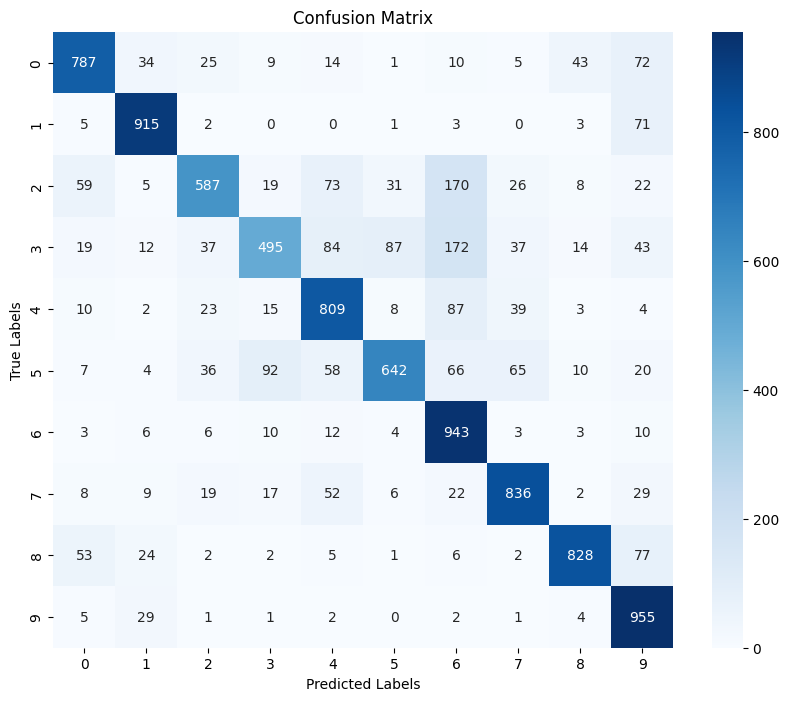

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
